<h1> Phenocam Greeness Index Extraction </h1>

This notebook performs greeness index (GCC, RCC, ExG) extraction from Phenocam time series images in Python. The steps and general workflow follows the illustration below:

<p align="center">
  <img src="figures/general_pipeline.png" width="70%"/>
</p>



## 📚 Table of Contents

0. [Installation and Environment Check](#0-installation)

1. [Hyperparameter Check](#1-hyperparameter-check)

   - [1.1 Edge Density Check](#01-edge-density-check)

   - [1.2 Auto Alignment Check](#02-auto-alignment-check)

2. [Reference Image Labelling](#2-reference-image-labelling)

3. [Greeness Index Extraction](#3-data-preparation)

   - [3.1 Helper Functions](#31-load-image-data)

   - [3.2 Global GCC](#31-load-image-data)

   - [3.3 Per Region of Interest GCC](#31-load-image-data)

   - [3.4 RCC & ExG](#32-load-roi-and-masks)

4. [Visualization](#4-processing)

   - [4.1 Key Parameters Extraction](#41-filtering)


## 0. Installation and Environment Check

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
import pandas as pd
import time
import json
from scipy.ndimage import distance_transform_edt
from skimage.draw import polygon
from skimage.measure import regionprops, label
from skimage.segmentation import find_boundaries
from skimage.restoration import wiener
from matplotlib.colors import LinearSegmentedColormap
from labelme.utils import shape_to_mask
from pvlib.location import Location
from scipy.optimize import curve_fit

These helper functions perform image pre-processing, calculate the Sun–Earth relative position, and extract datetime information from file names for subsequent filtering. Libraries used and functions introduced are detailed below.

In [8]:
def calculate_sza(dt, latitude_deg, longitude_deg, altitude_m=0):
    ''' Calculate solar zenith angle of certain location
        default altitude = 0[m]
    '''
    # Ensure dt is a pandas Timestamp
    dt = pd.Timestamp(dt)
    # Create location object
    site = Location(latitude=latitude_deg, longitude=longitude_deg, altitude=altitude_m)
    solar_position = site.get_solarposition(times=dt)
    sza_deg = solar_position['zenith'].values[0]
    return sza_deg

def readin_time(folder_path, UTC=False):
    ''' Convert file name strings to datetime variables
        Acceptable formats:
        1. ...YYYYMMDD_HHMMSS.jpg
        2. ...YYYYMMDD_HHMM.jpg
        3. ...YYYY_MM_DD_HH_MM_SS.jpg
    '''
    files = []
    time_list = []

    for fname in os.listdir(folder_path):
        match = re.search(
            r'(?:(\d{8})[_-](\d{6}|\d{4}))|(?:_(\d{4})_(\d{2})_(\d{2})_(\d{2})_(\d{2})_(\d{2}))',
            fname
        )
        if match:
            if match.group(1) and match.group(2):
                # Format: YYYYMMDD_HHMMSS or YYYYMMDD_HHMM
                date_part = match.group(1)
                time_part = match.group(2)
                if len(time_part) == 4:
                    time_part += "00"
                dt_str = date_part + time_part
            elif match.group(3):
                # Format: _YYYY_MM_DD_HH_MM_SS
                dt_str = f"{match.group(3)}{match.group(4)}{match.group(5)}{match.group(6)}{match.group(7)}{match.group(8)}"

            try:
                dt = datetime.strptime(dt_str, "%Y%m%d%H%M%S")
                if UTC:
                    dt -= timedelta(hours=4)  # Convert UTC to Toronto time (UTC-4)
                files.append((dt, fname))
                time_list.append(dt)
            except ValueError:
                print(f"Skipping invalid datetime: {fname} -> {dt_str}")

    files.sort()
    time_list.sort()
    return files, time_list

def apply_clahe(img, imshow = False):
    ''' Apply clahe (Contrast Limited Adaptive Histogram Equalization) filter to improve the contrast of the image
        https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
    '''
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l_eq = clahe.apply(l)

    lab_eq = cv2.merge((l_eq, a, b))
    img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    if imshow:
        cv2.imshow("Clahe", img_eq)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return img_eq

def wiener_deblur(img_gray, psf_size=5, imshow = False):
    ''' Apply deblur/deconvolution filter thorugh wiener algorithm
        https://docs.opencv.org/4.x/de/d3c/tutorial_out_of_focus_deblur_filter.html
    '''
    # Estimate a basic blur kernel (Gaussian)
    psf = np.ones((psf_size, psf_size)) / (psf_size ** 2)
    
    # Convert to float32 for processing
    img_float = img_gray.astype(np.float32) / 255.0
    
    # Apply Wiener deconvolution
    deblurred = wiener(img_float, psf, balance=0.1)
    deblurred = np.clip(deblurred * 255, 0, 255).astype(np.uint8)
    
    if imshow:
        cv2.imshow("Wiener deblur", deblurred)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return deblurred

def ensure_grayscale(img):
    ''' Apply grayscale filter for the image
    '''
    if len(img.shape) == 3 and img.shape[2] == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def edge_density(image, print_edge_density=False):
    ''' Calculate edge density of image
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size
    if print_edge_density:
        print("edge density", edge_density)
    return edge_density

In [51]:
def plot_dual_shadded(region_labels, mean_vals, std_vals, title, xlabel, ylabel, color):
    mean_vals = np.array(mean_vals)
    std_vals = np.array(std_vals)
    # Plot mean line
    plt.figure(figsize=(8, 6))
    plt.plot(region_labels, mean_vals, label='Mean error', color=color, linewidth=2)

    # Fill ±1 std
    plt.fill_between(region_labels, mean_vals, mean_vals + std_vals,
                    color=color, alpha=0.3, label='+1 Std Dev')

    # Fill min-max range
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
def plot_gcc_with_gap_breaks(dates, mean, std, title, ylabel, xlabel, color='green', threshold_days=14):
    dates = pd.to_datetime(dates)
    df = pd.DataFrame({'date': dates, 'mean': mean, 'std': std})
    df = df.sort_values('date')

    # Find where the gap exceeds threshold
    time_diff = df['date'].diff().dt.days
    gap_indices = time_diff > threshold_days

    # Split into segments
    segments = []
    start_idx = 0
    for i, is_gap in enumerate(gap_indices):
        if is_gap:
            segments.append(df.iloc[start_idx:i])
            start_idx = i
    segments.append(df.iloc[start_idx:])  # last segment

    # Plot each segment separately
    fig, ax = plt.subplots(figsize=(12, 4))
    for segment in segments:
        ax.plot(segment['date'], segment['mean'], color=color, linewidth=2)
        ax.fill_between(segment['date'],
                        segment['mean'] - segment['std'],
                        segment['mean'] + segment['std'],
                        color=color, alpha=0.3)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend(["Mean", "±1 Std Dev"])
    #plt.ylim(0.2, 0.6)
    plt.tight_layout()

The directories for the image folder, reference image (latest frame), ideal-lighting images, and non-ideal lighting images should be declared as global variables in this section, prepared for hyperparameter check.

<p align="center">
  <img src="figures/directory.png" width="70%"/>
</p>


In [ ]:
FOLDER_DIR = "/Volumes/Aiqi_02/phenocams/tame_phenocams/test/"
NON_IDEAL_SET_NAME = 'edge_density_check_set/blurred/'
IDEAL_SET_NAME = 'edge_density_check_set/normal/'
FULL_IMAGES_SET = 'data/'
REF_IMAGE = 'reference_figure.jpg'

VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

Hyperparameters such as location latitude and longitude should be specified. The time threshold and solar zenith angle (SZA) threshold define the acceptable time window for image acquisition, typically around noon when shadows are minimal. Images are only captured if the SZA is below the specified threshold. The ignored region refers to areas in the image (such as metadata labels) that are excluded from analysis to prevent alignment errors.

In [11]:
local_lattitude = 43.663889  # Toronto
local_longitude = -79.395656  # Toronto

time_threshold_1 = 10 # 10AM
time_threshold_2 = 15 # 3PM
sza_threshold = 80

region_to_ignore = 8 # ignore upper 1/x of the figure (sky & metadata of camera)

## 1. Hyperparameter Check
### 1.1 Edge Density Checks

<p align="center">
  <img src="figures/edge_density.png" width="70%"/>
</p>


In [ ]:
edge_density_ideal = []
for filename in sorted(os.listdir(FOLDER_DIR + IDEAL_SET_NAME)):
    filepath = os.path.join(FOLDER_DIR + IDEAL_SET_NAME, filename)
    img = cv2.imread(filepath)
    if img is None:
        continue
    edge_density_ideal.append(edge_density(img))

edge_density_non_ideal = []
for filename in sorted(os.listdir(FOLDER_DIR + NON_IDEAL_SET_NAME)):
    filepath = os.path.join(FOLDER_DIR + NON_IDEAL_SET_NAME, filename)
    img = cv2.imread(filepath)
    if img is None:
        continue
    edge_density_non_ideal.append(edge_density(img))

ideal_mean = np.average(edge_density_ideal)
ideal_std = np.sqrt(np.average((edge_density_ideal - ideal_mean) ** 2))
print("Ideal lighting condition edge density mean value:", ideal_mean, ", standard deviation:", ideal_std)

non_ideal_mean = np.average(edge_density_non_ideal)
non_ideal_std = np.sqrt(np.average((edge_density_non_ideal - non_ideal_mean) ** 2))
print("Non Ideal lighting condition edge density mean value:", non_ideal_mean, ", standard deviation:", non_ideal_std)

Premature end of JPEG file


Ideal lighting condition edge density mean value: 0.014411488498958496 , standard deviation: 0.004755795484479258
Ideal lighting condition edge density mean value: 0.0047916607129248594 , standard deviation: 0.0027361159338650408


Base on the results, the edge density threshold should be set as 0.008.

### 1.2 Auto Alignment Check
### 1.2.1 auto alignment inspection

In [ ]:
def akaze_affine_transformation(ref_img, cur_img, k, ransac_prog_threshold, ratio_thresh, imshow = False):
    h, w = ref_img.shape[:2]
    ref_img = apply_clahe(ref_img)
    cur_img = apply_clahe(cur_img)
    ref_img = wiener_deblur(ensure_grayscale(ref_img))
    cur_img = wiener_deblur(ensure_grayscale(cur_img))

    # Masks to ignore upper 1/k and lower 1/k
    mask_ref = np.zeros((h, w), dtype=np.uint8)
    mask_cur = np.zeros((h, w), dtype=np.uint8)
    mask_ref[h//k: (h//k)*(k-1), :] = 255
    mask_cur[h//k: (h//k)*(k-1), :] = 255

    akaze = cv2.AKAZE_create(
        threshold=0.0002,
        nOctaves=6,
        nOctaveLayers=8,
        diffusivity=cv2.KAZE_DIFF_CHARBONNIER
    )

    # After CLAHE + Sharpening
    kp1, des1 = akaze.detectAndCompute(ref_img, mask_ref)
    kp2, des2 = akaze.detectAndCompute(cur_img, mask_cur)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    try:
        matches_knn = bf.knnMatch(des1, des2, k=2)
        good_matches = [m for m, n in matches_knn if m.distance < ratio_thresh * n.distance]
    except cv2.error as e:
        print("OpenCV error during knnMatch:", e)
        return None, None, None, None

    if len(good_matches) < 4:
        print("Too few good matches:", len(good_matches))
        return None, None, None, None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)


    # Estimate 6-DoF affine transformation
    A, inlier_mask = cv2.findHomography(
        dst_pts, src_pts, method=cv2.USAC_MAGSAC, ransacReprojThreshold=ransac_prog_threshold
    )

    inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inlier_mask[i]]
    if imshow:
        img_inliers = cv2.drawMatches(ref_img, kp1, cur_img, kp2, inlier_matches, None, flags=2)
        cv2.imshow("Inlier Matches", img_inliers)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    if A is None or inlier_mask is None:
        print(f"Warning: Affine estimation failed for k={k}")
        return None, None, None, None
    
    inlier_sharpness = [
    kp1[m.queryIdx].response
        for i, m in enumerate(good_matches)
        if inlier_mask[i]
    ]
    
    return A, dst_pts, src_pts, inlier_mask

def goodness_of_match_homography(H, dst_pts, src_pts, inlier_mask, k):
    inliers_dst = dst_pts[inlier_mask.ravel() == 1]
    inliers_src = src_pts[inlier_mask.ravel() == 1]

    # Filter to bottom 1/k of the image height (optional)
    h = np.max(inliers_src[:, :, 1])
    keep_indices = inliers_src[:, 0, 1] > (h / k)
    inliers_dst = inliers_dst[keep_indices]
    inliers_src = inliers_src[keep_indices]

    # Apply homography transformation
    dst_pts_proj = cv2.perspectiveTransform(inliers_dst, H)

    # Compute Euclidean error
    errors = np.linalg.norm(dst_pts_proj.squeeze() - inliers_src.squeeze(), axis=1)

    # Percentage of points with error < 2 pixels
    below = np.sum(errors < 2) / len(errors) * 100
    inlier_ratio = np.sum(inlier_mask) / len(inlier_mask)

    return np.mean(errors), np.median(errors), np.max(errors), np.std(errors), inlier_ratio

def image_alignment_inspect(folder_dir, image_folder_name, ref_image_name, region_to_ignore, 
                    local_lattitude, local_longitude, sample_interval, time_threshold_1, time_threshold_2,
                    sza_threshold, edge_density_threshold, ransac_prog_threshold, ratio_thresh, inspect_first_n_pics,
                    imshow = False):
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    image_folder_path = folder_dir + image_folder_name
    ref_image_path = folder_dir + ref_image_name

    ref_img = cv2.imread(ref_image_path, cv2.IMREAD_COLOR)

    files, dt = readin_time(image_folder_path)
    sza = [calculate_sza(t, local_lattitude, local_longitude) for t in dt]
    columns = ['Filename', 'Datetime', 'SZA']
    readin_df = pd.DataFrame(columns=columns)

    for i, (t, name) in enumerate(files):
        if t.hour >= time_threshold_1 and t.hour <= time_threshold_2 and sza[i] <= sza_threshold:
            readin_df.loc[len(readin_df)] = [name, t, sza[i]]

    readin_df["Filename"] = image_folder_path + readin_df["Filename"]
    readin_df_sampled = readin_df.iloc[::sample_interval].reset_index(drop=True)

    columns = ['datetime', 'e_mean', 'e_median', 'e_max', 'e_std', 'inlier_ratio'] + \
              [f'A{i}{j}' for i in range(3) for j in range(3)]  # 2x3 affine matrix
    error_df = pd.DataFrame(columns=columns)
    
    i = 0
    for index, row in readin_df_sampled.iterrows():
        filename = row['Filename']
        file_time = row['Datetime']
        # =======================
        # 1. Filter
        # =======================
        ### filter out non valird extensions
        if not filename.lower().endswith(VALID_EXTENSIONS):
            print(f"Failed to read image: {filename}")
            continue

        ### set cutoff date -> starting from cutoff date (in case of camera moves totally to the otherside)
        # if row["Datetime"] < cutoff1:
        #    continue

        cur_img = cv2.imread(filename)
        if edge_density(cur_img) <= edge_density_threshold:
            continue

        # =======================
        # 2. Transformation & error calculation
        # =======================
        result = akaze_affine_transformation(ref_img, cur_img, region_to_ignore, ransac_prog_threshold, ratio_thresh)
        if result is None or any(r is None for r in result):
            continue
        A, dst_pts, src_pts, inlier_mask = result
        e_mean, e_median, e_max, e_std, inlier_ratio = goodness_of_match_homography(A, dst_pts, src_pts, inlier_mask, region_to_ignore)

        # =======================
        # 3. Plot aligned image with ref image
        # =======================
        if imshow:
            aligned_img = cv2.warpPerspective(cur_img, A, (ref_img.shape[1], ref_img.shape[0]))
            blended = cv2.addWeighted(ref_img, 0.5, aligned_img, 0.5, 0)

            # Convert BGR (OpenCV format) to RGB (Matplotlib format)
            blended_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(8, 8))
            plt.imshow(blended_rgb)
            plt.title("Overlap of Reference and Aligned Image")
            plt.axis('off')
            plt.show()
        # =======================
        # 4. Save transformation matrix & errors
        # =======================
        A = A.flatten()
        row = [file_time, e_mean, e_median, e_max, e_std, inlier_ratio] + A.tolist()
        error_df.loc[len(error_df)] = row
        print(file_time)
        print("error stats: mean ", e_mean, ", median", e_median, ", max",e_max , ", standard deviation", e_std)
        print("inlier ratio:", inlier_ratio)
        i += 1
        if i >= inspect_first_n_pics:
            break
        
    return error_df

In [36]:
edge_density_threshold = 0.008
ransac_prog_threshold = 5 #pixel
ratio_thresh = 0.6
sample_interval = 200
inspect_first_n_pics = 3
inlier_ratio_threshold = 0.6

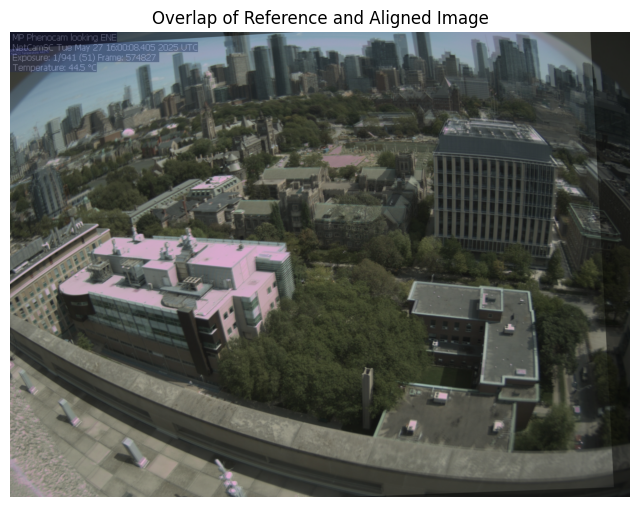

2022-09-01 12:00:01
error stats: mean  2.7507138 , median 2.8616467 , max 4.991165 , standard deviation 1.2142957
inlier ratio: 0.6085106382978723


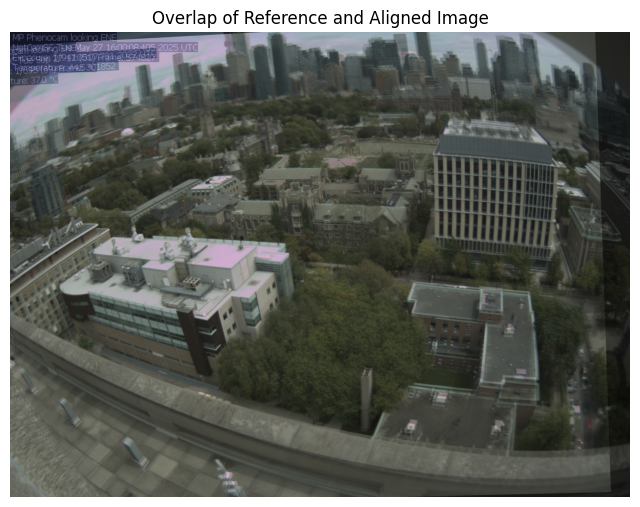

2022-09-27 13:00:01
error stats: mean  2.445635 , median 2.3379495 , max 4.998441 , standard deviation 1.1804132
inlier ratio: 0.6909460243760882


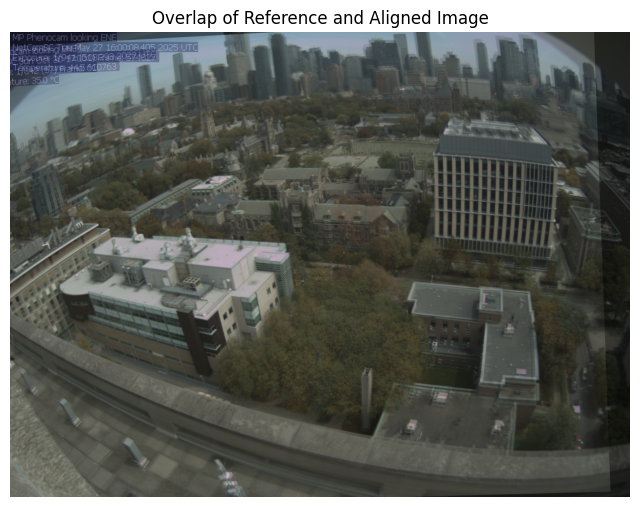

2022-10-30 13:00:01
error stats: mean  2.8919132 , median 2.8769023 , max 4.9946437 , standard deviation 1.140968
inlier ratio: 0.6733067729083665


In [ ]:
image_alignment_inspect(FOLDER_DIR, FULL_IMAGES_SET, REF_IMAGE, region_to_ignore, 
    local_lattitude, local_longitude, sample_interval, time_threshold_1, time_threshold_2, sza_threshold,
    edge_density_threshold, ransac_prog_threshold, ratio_thresh, inspect_first_n_pics, imshow = True)

### 1.2.2 Error Stats

In [23]:
def image_alignment_stats(folder_dir, image_folder_name, ref_image_name, region_to_ignore, 
                    local_lattitude, local_longitude, sample_interval, time_threshold_1, time_threshold_2,
                    sza_threshold, edge_density_threshold, ransac_prog_threshold, ratio_thresh, inspect_first_n_pics,
                    imshow = False):
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    image_folder_path = folder_dir + image_folder_name
    ref_image_path = folder_dir + ref_image_name

    ref_img = cv2.imread(ref_image_path, cv2.IMREAD_COLOR)

    files, dt = readin_time(image_folder_path)
    sza = [calculate_sza(t, local_lattitude, local_longitude) for t in dt]
    columns = ['Filename', 'Datetime', 'SZA']
    readin_df = pd.DataFrame(columns=columns)

    for i, (t, name) in enumerate(files):
        if t.hour >= time_threshold_1 and t.hour <= time_threshold_2 and sza[i] <= sza_threshold:
            readin_df.loc[len(readin_df)] = [name, t, sza[i]]

    readin_df["Filename"] = image_folder_path + readin_df["Filename"]
    readin_df_sampled = readin_df.iloc[::sample_interval].reset_index(drop=True)

    columns = ['datetime', 'e_mean', 'e_median', 'e_max', 'e_std', 'inlier_ratio'] + \
              [f'A{i}{j}' for i in range(3) for j in range(3)]  # 2x3 affine matrix
    error_df = pd.DataFrame(columns=columns)
    
    for index, row in readin_df_sampled.iterrows():
        filename = row['Filename']
        file_time = row['Datetime']
        ### filter out non valird extensions
        if not filename.lower().endswith(VALID_EXTENSIONS):
            print(f"Failed to read image: {filename}")
            continue

        cur_img = cv2.imread(filename)
        if edge_density(cur_img) <= edge_density_threshold:
            continue

        result = akaze_affine_transformation(ref_img, cur_img, region_to_ignore, ransac_prog_threshold, ratio_thresh)
        if result is None or any(r is None for r in result):
            continue
        A, dst_pts, src_pts, inlier_mask = result
        e_mean, e_median, e_max, e_std, inlier_ratio = goodness_of_match_homography(A, dst_pts, src_pts, inlier_mask, region_to_ignore)

        if imshow:
            aligned_img = cv2.warpPerspective(cur_img, A, (ref_img.shape[1], ref_img.shape[0]))
            blended = cv2.addWeighted(ref_img, 0.5, aligned_img, 0.5, 0)

            # Convert BGR (OpenCV format) to RGB (Matplotlib format)
            blended_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(8, 8))
            plt.imshow(blended_rgb)
            plt.title("Overlap of Reference and Aligned Image")
            plt.axis('off')
            plt.show()

        A = A.flatten()
        row = [file_time, e_mean, e_median, e_max, e_std, inlier_ratio] + A.tolist()
        error_df.loc[len(error_df)] = row
    return error_df

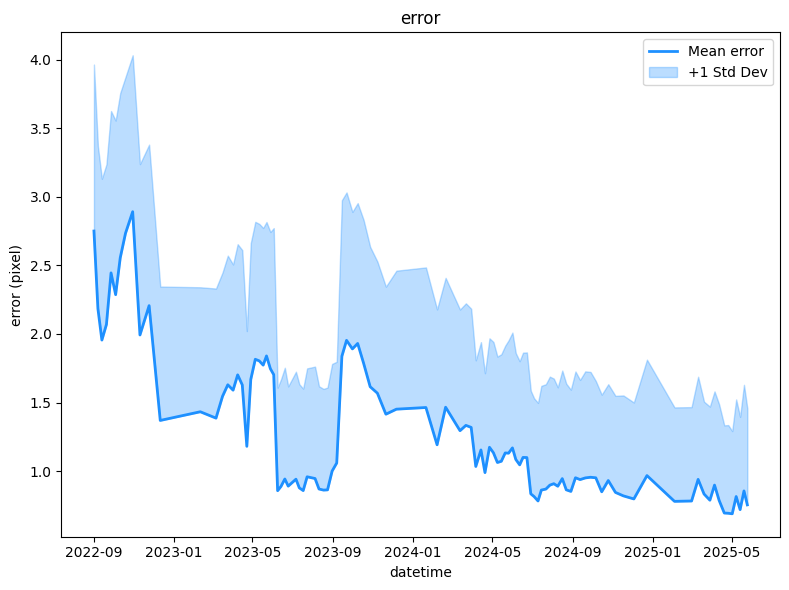

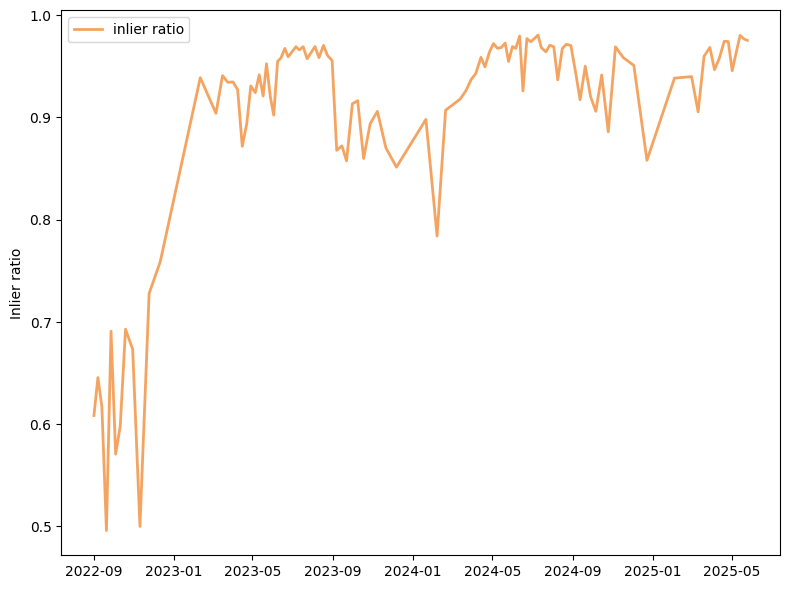

In [28]:
TRANSFORMATION_REF_DIR = "transformation.csv" 
sample_interval = 50
error_df = image_alignment_stats(FOLDER_DIR, FULL_IMAGES_SET, REF_IMAGE, region_to_ignore, 
                local_lattitude, local_longitude, sample_interval, time_threshold_1, time_threshold_2, sza_threshold,
                edge_density_threshold, ransac_prog_threshold, ratio_thresh, inspect_first_n_pics, imshow = False)

error_df.to_csv(FOLDER_DIR + 'transformation.csv', index=False)
plot_dual_shadded(error_df["datetime"], error_df["e_mean"], error_df["e_std"], "error", "datetime", "error (pixel)", "dodgerblue")

plt.figure(figsize=(8, 6))
plt.plot(error_df['datetime'], error_df['inlier_ratio'], label='inlier ratio', color='sandybrown', linewidth=2)
plt.ylabel('Inlier ratio')
plt.tight_layout()
plt.legend()
plt.show()


### 2. Reference Image Labelling

<p align="center">
  <img src="figures/roi_labelling.png" width="80%"/>
</p>
<p align="center">
  <img src="figures/roi_labelling2.png" width="80%"/>
</p>

Run in terminal (Labelme)

In [39]:
ROI_JSON = "reference_roi_jun13.json"

<h2> 3. Greeness index extraction </h2>
Using soft-boundary as defined mask for greeness index extraction, the boundary has been set to auto-adjust for the alignment error.

<p align="center">
  <img src="figures/soft_boundary.png" width="70%"/>
</p>
<p align="center">
  <img src="figures/soft_boundary2.png" width="70%"/>
</p>



<h3> 3.1 Helper Function </h3>

In [ ]:
def readin_single_name_time(fname, UTC=False):
    dt = False

    # Match formats:
    # 1. ...YYYYMMDD_HHMMSS.jpg or .png
    # 2. ...YYYYMMDD_HHMM.jpg

    match = re.search(
        r'(?:(\d{8})[_-](\d{6}|\d{4}))|(?:_(\d{4})_(\d{2})_(\d{2})_(\d{2})_(\d{2})_(\d{2}))',
        fname
    )

    if match:
        try:
            if match.group(1) and match.group(2):
                date_part = match.group(1)
                time_part = match.group(2)
                if len(time_part) == 4:
                    dt_str = date_part + time_part + "00"
                else:
                    dt_str = date_part + time_part
                dt = datetime.strptime(dt_str, "%Y%m%d%H%M%S")
            elif match.group(3):
                # Format: _YYYY_MM_DD_HH_MM_SS
                dt_str = f"{match.group(3)}{match.group(4)}{match.group(5)}{match.group(6)}{match.group(7)}{match.group(8)}"
                dt = datetime.strptime(dt_str, "%Y%m%d%H%M%S")

            if UTC:
                dt -= timedelta(hours=4)  # Convert UTC to Toronto local time
        except ValueError as e:
            print(f"Failed to parse time: {dt_str}, error: {e}")
    else:
        print(f"No match for: {fname}")

    return dt

def check_time_SZA(fname, time_threshold_1, time_threshold_2, sza_threshold, latitude_deg, longitude_deg):
    dt = readin_single_name_time(fname)
    if dt == False:
        return False
    sza = calculate_sza(dt, latitude_deg, longitude_deg)
    if dt.hour >= time_threshold_1 and dt.hour <= time_threshold_2 and sza <= sza_threshold:
        return True
    return False

def get_union_mask_from_json(data, width, height):
    union_mask = np.zeros((height, width), dtype=bool)

    for shape in data['shapes']:
        mask = shape_to_mask((height, width), shape['points'], shape_type=shape['shape_type'])
        union_mask |= mask

    return union_mask

def soft_interior_weight(d, e_mean=0, e_std=0, min_weight=0.05):
    w = np.ones_like(d)
    transition_zone = (d >= 0) & (d < e_mean)
    falloff = np.exp(-0.5 * ((e_mean - d[transition_zone]) / e_std) ** 2)
    w[transition_zone] = np.clip(falloff, min_weight, 1)
    w[d < 0] = 0
    return w

def generate_soft_interior_mask(union_mask, e_mean=0, e_std=0, show_plot=False):
    height, width = union_mask.shape
    weight_mask = np.zeros((height, width), dtype=float)

    labeled = label(union_mask)
    props = regionprops(labeled)

    for region in props:
        minr, minc, maxr, maxc = region.bbox
        region_mask = region.image.astype(bool)

        # Define the edge more clearly using boundary detection
        boundaries = find_boundaries(region_mask, mode='inner')
        dist_to_edge = distance_transform_edt(~boundaries)

        # Weighting logic
        local_weight = soft_interior_weight(dist_to_edge, e_mean, e_std)

        # Mask it to stay within the polygon only
        local_weight *= region_mask

        # Combine into global mask
        weight_mask[minr:maxr, minc:maxc] = np.maximum(
            weight_mask[minr:maxr, minc:maxc],
            local_weight
        )

    if show_plot:
        black_to_white = LinearSegmentedColormap.from_list("black_to_white", ["brown", "green"])
        plt.figure(figsize=(6, 5))
        plt.imshow(weight_mask, cmap=black_to_white, vmin=0, vmax=1)
        plt.title(f"Soft Interior Mask (e_mean={e_mean:.2f}, e_std={e_std:.2f})")
        plt.colorbar(label="Weight")
        plt.tight_layout()
        plt.show()

    return weight_mask

def compute_weighted_gcc(image, weight_mask, show_heatmap=False):
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    black_mask = (R == 0) & (G == 0) & (B == 0)

    # GCC calculation
    denominator = R + G + B
    denominator[denominator == 0] = np.nan
    GCC = G / denominator
    GCC[black_mask] = np.nan  # Optional: mark black pixels explicitly

    # Apply weights only to valid, non-black, non-NaN pixels
    valid_mask = (weight_mask > 0) & ~black_mask & ~np.isnan(GCC)
    gcc_values = GCC[valid_mask]
    weights = weight_mask[valid_mask]

    if len(gcc_values) == 0:
        print("No valid pixels in ROI")
        return np.nan, np.nan, np.nan, np.nan
    
    if show_heatmap:
        green_to_white = LinearSegmentedColormap.from_list("green_to_white", ["brown", "green"])
        heatmap = np.full_like(GCC, np.nan)
        heatmap[valid_mask] = GCC[valid_mask]
        plt.figure(figsize=(6, 5))
        plt.imshow(heatmap, cmap=green_to_white, vmin=0.25, vmax=0.4)
        plt.colorbar(label="GCC value")
        plt.title("Local GCC Heatmap (Green → Brown)")
        plt.tight_layout()
        plt.show()

    weighted_mean = np.average(gcc_values, weights=weights)
    weighted_std = np.sqrt(np.average((gcc_values - weighted_mean) ** 2, weights=weights))
    gcc_min = np.min(gcc_values)
    gcc_max = np.max(gcc_values)

    return weighted_mean, weighted_std, gcc_min, gcc_max

<h3> 3.2 Global GCC Calculation</h3>
<h4> 3.2.1 Global GCC Calculation without Auto-alignment</h4>

In [41]:
def gcc_without_autoalignment(folder_dir, image_folder_name, ref_image_name, roi_json,
        time_threshold_1, time_threshold_2, sza_threshold, edge_density_threshold, 
        local_lattitude, local_longitude):
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    
    ### Load Affine Transformation Reference Image
    ref_img = cv2.imread(folder_dir + ref_image_name)
    ref_img_width = ref_img.shape[1]
    ref_img_height = ref_img.shape[0]

    ### Load mask
    with open(folder_dir + roi_json, 'r') as f:
        data = json.load(f)
    
    ### Load Images -> do SZA check + similarity check
    i = 0
    date_list = []
    global_mean = []
    global_std = []
    global_min = []
    global_max = []

    union_mask = get_union_mask_from_json(data, ref_img_width, ref_img_height)    

    for filename in sorted(os.listdir(folder_dir + image_folder_name)):
        i += 1
        filepath = os.path.join(folder_dir + image_folder_name, filename)


        if not filename.lower().endswith(VALID_EXTENSIONS):
            continue  # Skip .DS_Store and other non-image files
        if not check_time_SZA(filename, time_threshold_1, time_threshold_2, sza_threshold, local_lattitude, local_longitude):
            continue # Skip if not in correct SZA threshold and daytime

        file_time = readin_time(filename)

        img = cv2.imread(filepath)
        if img is None:
            continue
        if edge_density(img) <= edge_density_threshold:
            continue

        img = img.astype(np.float32)
        
        # Step 1: Load binary ROI mask
        weighted_mask = generate_soft_interior_mask(union_mask)
        mean, std, min_val, max_val = compute_weighted_gcc(img, weighted_mask)

        global_mean.append(mean)
        global_std.append(std)
        global_min.append(min_val)
        global_max.append(max_val)
        date_list.append(file_time)
        print(file_time, mean)

    df = pd.DataFrame({
        "datetime": date_list,
        "mean": global_mean,
        "std": global_std,
        "min": global_min,
        "max": global_max
    })

    return df

In [ ]:
df = gcc_without_autoalignment(FOLDER_DIR, FULL_IMAGES_SET, REF_IMAGE, ROI_JSON,
        time_threshold_1, time_threshold_2, sza_threshold, edge_density_threshold, 
        local_lattitude, local_longitude)

AUTO_ALIGNED_GCC = "gcc_global_02.csv"
df.to_csv(FOLDER_DIR + AUTO_ALIGNED_GCC, index=False)

<h4> 3.2.2 Global GCC with Auto-alignment</h4>

In [ ]:
def gcc_with_auto_alignment(folder_dir, image_folder_name, ref_image_name, transformation_csv, roi_json,
        time_threshold_1, time_threshold_2, sza_threshold, edge_density_threshold, 
        local_lattitude, local_longitude, inlier_ratio_threshold):
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    ### Load Affine Transformation Reference Dataframe
    t_df = pd.read_csv(folder_dir + transformation_csv)
    t_df['datetime'] = pd.to_datetime(t_df['datetime'])
    A_cols = ['A00', 'A01', 'A02', 'A10', 'A11', 'A12']
    t_df['A_matrix'] = t_df[A_cols].apply(
        lambda row: np.array([[row['A00'], row['A01'], row['A02']],
                            [row['A10'], row['A11'], row['A12']]]), axis=1)
    

    ### Load Affine Transformation Reference Image
    ref_img = cv2.imread(folder_dir + ref_image_name)
    ref_img_width = ref_img.shape[1]
    ref_img_height = ref_img.shape[0]

    ### Load mask
    with open(folder_dir + roi_json, 'r') as f:
        data = json.load(f)
    
    ### Load Images -> do SZA check + similarity check
    i = 0
    date_list = []
    global_mean = []
    global_std = []
    global_min = []
    global_max = []

    union_mask = get_union_mask_from_json(data, ref_img_width, ref_img_height)    

    for filename in sorted(os.listdir(folder_dir + image_folder_name)):
        i += 1
        filepath = os.path.join(folder_dir + image_folder_name, filename)

        ### 3). SZA & time check
        if not filename.lower().endswith(VALID_EXTENSIONS):
            continue  # Skip .DS_Store and other non-image files
        if not check_time_SZA(filename, time_threshold_1, time_threshold_2, sza_threshold, local_lattitude, local_longitude):
            continue # Skip if not in correct SZA threshold and daytime

        file_time = readin_single_name_time(filename)
        img = cv2.imread(filepath)
        if img is None:
            continue
        if edge_density(img) <= edge_density_threshold:
            continue

        time_diffs = np.abs(t_df['datetime'] - file_time)
        row_number = t_df.index.get_loc(time_diffs.idxmin())

        valid_row = None
        for offset in range(0, row_number + 1):
            candidate_row = row_number - offset
            if t_df.iloc[candidate_row]['inlier_ratio'] > inlier_ratio_threshold:
                valid_row = candidate_row
                break

        # Skip if no valid transformation is found
        if valid_row is None:
            continue

        Affine_matrix = t_df.iloc[valid_row].loc["A_matrix"]
        e_mean = t_df.iloc[valid_row].loc["e_mean"]
        e_std = t_df.iloc[valid_row].loc["e_std"]

        img = cv2.warpAffine(img, Affine_matrix, (ref_img_width, ref_img_height))
        img = img.astype(np.float32)
        
        # Step 1: Load binary ROI mask
        weighted_mask = generate_soft_interior_mask(union_mask, e_mean=e_mean, e_std=e_std)
        mean, std, min_val, max_val = compute_weighted_gcc(img, weighted_mask)

        global_mean.append(mean)
        global_std.append(std)
        global_min.append(min_val)
        global_max.append(max_val)
        date_list.append(file_time)
        print(file_time, mean)

    df = pd.DataFrame({
        "datetime": date_list,
        "mean": global_mean,
        "std": global_std,
        "min": global_min,
        "max": global_max
    })

    return df

In [ ]:
df = gcc_with_auto_alignment(FOLDER_DIR, FULL_IMAGES_SET, REF_IMAGE, TRANSFORMATION_REF_DIR, ROI_JSON,
        time_threshold_1, time_threshold_2, sza_threshold, edge_density_threshold, 
        local_lattitude, local_longitude, inlier_ratio_threshold)
WITH_ALIGNED_GCC = "gcc_with_aligned.csv"
df.to_csv(FOLDER_DIR + AUTO_ALIGNED_GCC, index=False)

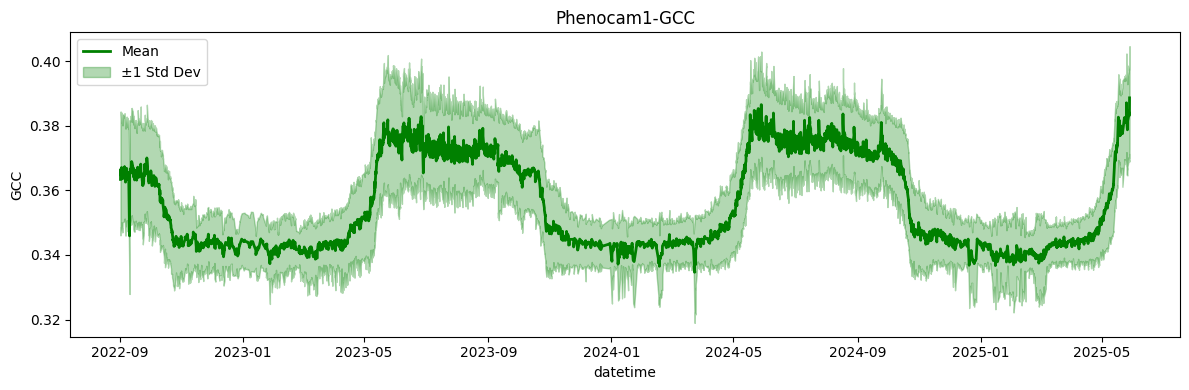

In [49]:
AUTO_ALIGNED_GCC = "gcc_global_02.csv"
df = pd.read_csv(FOLDER_DIR + AUTO_ALIGNED_GCC)
plot_gcc_with_gap_breaks(df['datetime'], df['mean'], df['std'], 'Phenocam1-GCC', 'GCC', "datetime")
plt.tight_layout()
plt.show()

<h3> 3.3 GCC per Region of Interest </h3>

In [ ]:
def save_roi_label_mapping(json_path, output_csv_path="roi_label_mapping.csv"):
    import json
    import pandas as pd

    with open(json_path, 'r') as f:
        data = json.load(f)

    # LabelMe format — ROIs are in the "shapes" key
    if "shapes" not in data:
        raise ValueError("Expected key 'shapes' not found in the JSON file.")

    roi_data = data["shapes"]

    roi_label_mapping = []
    for roi_id, roi in enumerate(roi_data):
        label = roi.get("label", f"ROI_{roi_id}")
        roi_label_mapping.append({
            "roi_id": roi_id,
            "label": label
        })

    df_mapping = pd.DataFrame(roi_label_mapping)
    df_mapping.to_csv(output_csv_path, index=False)
    print(f"✅ ROI label mapping saved to: {output_csv_path}")

def generate_soft_interior_masks(union_mask, e_mean=0, e_std=0, show_plot=False):
    """
    Generate a list of soft interior weight masks for each individual ROI region in a union_mask.
    """
    height, width = union_mask.shape
    labeled = label(union_mask)
    props = regionprops(labeled)
    roi_weight_masks = []

    for region in props:
        minr, minc, maxr, maxc = region.bbox
        region_mask = region.image.astype(bool)

        boundaries = find_boundaries(region_mask, mode='inner')
        dist_to_edge = distance_transform_edt(~boundaries)
        local_weight = soft_interior_weight(dist_to_edge, e_mean, e_std)
        local_weight *= region_mask  # zero out pixels outside polygon

        # Create a full-sized mask with weights only in the bounding box
        full_weight_mask = np.zeros((height, width), dtype=float)
        full_weight_mask[minr:maxr, minc:maxc] = local_weight

        roi_weight_masks.append(full_weight_mask)

        if show_plot:
            cmap = LinearSegmentedColormap.from_list("black_to_white", ["brown", "green"])
            plt.figure(figsize=(5, 4))
            plt.imshow(full_weight_mask, cmap=cmap, vmin=0, vmax=1)
            plt.title(f"Soft Mask for ROI #{len(roi_weight_masks)-1}")
            plt.colorbar(label="Weight")
            plt.tight_layout()
            plt.show()

    return roi_weight_masks

def compute_weighted_gcc_per_roi(image, weight_masks, show_heatmap=False):
    """
    Compute weighted GCC stats for each ROI.

    Parameters:
    - image: HxWx3 RGB image.
    - weight_masks: list of HxW masks (same shape as image, values in [0,1]).
    - show_heatmap: bool, whether to show the GCC heatmap for the last ROI.

    Returns:
    - stats: list of (mean, std, min, max) tuples, one per ROI.
    """
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    black_mask = (R == 0) & (G == 0) & (B == 0)

    denominator = R + G + B
    denominator[denominator == 0] = np.nan
    GCC = G / denominator
    GCC[black_mask] = np.nan

    stats = []

    for idx, weight_mask in enumerate(weight_masks):
        valid_mask = (weight_mask > 0) & ~black_mask & ~np.isnan(GCC)
        gcc_values = GCC[valid_mask]
        weights = weight_mask[valid_mask]

        if len(gcc_values) == 0:
            stats.append((np.nan, np.nan, np.nan, np.nan))
            continue

        if show_heatmap and idx == len(weight_masks) - 1:
            green_to_white = LinearSegmentedColormap.from_list("green_to_white", ["brown", "green"])
            heatmap = np.full_like(GCC, np.nan)
            heatmap[valid_mask] = GCC[valid_mask]
            plt.figure(figsize=(6, 5))
            plt.imshow(heatmap, cmap=green_to_white, vmin=0.25, vmax=0.4)
            plt.colorbar(label="GCC value")
            plt.title(f"GCC Heatmap for ROI {idx} (Green → Brown)")
            plt.tight_layout()
            plt.show()

        weighted_mean = np.average(gcc_values, weights=weights)
        weighted_std = np.sqrt(np.average((gcc_values - weighted_mean) ** 2, weights=weights))
        gcc_min = np.min(gcc_values)
        gcc_max = np.max(gcc_values)

        stats.append((weighted_mean, weighted_std, gcc_min, gcc_max))

    return stats

<h4> 3.3.1 GCC per Region of Interest without Auto-alignment </h4>

In [ ]:
def gcc_per_roi_without_autoalignment(folder_dir, image_folder_name, ref_image_name, roi_json,
        time_threshold, sza_threshold, edge_density_threshold, 
        local_lattitude, local_longitude, inlier_ratio_threshold):
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    
    ### Load Affine Transformation Reference Image
    ref_img = cv2.imread(folder_dir + ref_image_name)
    ref_img_width = ref_img.shape[1]
    ref_img_height = ref_img.shape[0]

    ### Load mask
    with open(folder_dir + roi_json, 'r') as f:
        data = json.load(f)
    
    ### Load Images -> do SZA check + similarity check
    i = 0
    roi_stats_list = []

    union_mask = get_union_mask_from_json(data, ref_img_width, ref_img_height)    

    for filename in sorted(os.listdir(folder_dir + image_folder_name)):
        i += 1
        filepath = os.path.join(folder_dir + image_folder_name, filename)

        ### 3). SZA & time check
        if not filename.lower().endswith(VALID_EXTENSIONS):
            continue  # Skip .DS_Store and other non-image files
        if not check_time_SZA(filename, time_threshold, sza_threshold, local_lattitude, local_longitude):
            continue # Skip if not in correct SZA threshold and daytime

        file_time = readin_time(filename)
        img = cv2.imread(filepath)
        if img is None:
            continue
        if edge_density(img) <= edge_density_threshold:
            continue

        img = img.astype(np.float32)
        
        # Step 1: Load binary ROI mask
        weighted_masks = generate_soft_interior_masks(union_mask)
        roi_stats = compute_weighted_gcc_per_roi(img, weighted_masks)
        print(file_time)
        for roi_id, (mean, std, min_val, max_val) in enumerate(roi_stats):
            roi_stats_list.append({
                "datetime": file_time,
                "roi_id": roi_id,
                "mean": mean,
                "std": std,
                "min": min_val,
                "max": max_val
            })

    df = pd.DataFrame(roi_stats_list)
    return df

In [ ]:
df = gcc_per_roi_without_autoalignment(FOLDER_DIR, FULL_IMAGES_SET, REF_IMAGE, ROI_JSON,
        time_threshold_1, time_threshold_2, sza_threshold, edge_density_threshold, 
        local_lattitude, local_longitude, inlier_ratio_threshold)
PER_ROI_GCC_WITHOUT_ALIGNMENT = "gcc_roi_without_alignment.csv"
df.to_csv(FOLDER_DIR + PER_ROI_GCC_WITHOUT_ALIGNMENT, index=False)

<h4> 3.3.2 GCC per Region of Interest with Auto-alignment </h4>

In [ ]:
def gcc_per_roi_with_autoalignment(folder_dir, image_folder_name, ref_image_name, roi_json,
        time_threshold, sza_threshold, edge_density_threshold, 
        local_lattitude, local_longitude, inlier_ratio_threshold):
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    
    ### Load Affine Transformation Reference Image
    ref_img = cv2.imread(folder_dir + ref_image_name)
    ref_img_width = ref_img.shape[1]
    ref_img_height = ref_img.shape[0]

    ### Load mask
    with open(folder_dir + roi_json, 'r') as f:
        data = json.load(f)
    
    ### Load Images -> do SZA check + similarity check
    i = 0
    roi_stats_list = []

    union_mask = get_union_mask_from_json(data, ref_img_width, ref_img_height)    

    for filename in sorted(os.listdir(folder_dir + image_folder_name)):
        i += 1
        filepath = os.path.join(folder_dir + image_folder_name, filename)

        ### 3). SZA & time check
        if not filename.lower().endswith(VALID_EXTENSIONS):
            continue  # Skip .DS_Store and other non-image files
        if not check_time_SZA(filename, time_threshold, sza_threshold, local_lattitude, local_longitude):
            continue # Skip if not in correct SZA threshold and daytime

        file_time = readin_time(filename)
        img = cv2.imread(filepath)
        if img is None:
            continue
        if edge_density(img) <= edge_density_threshold:
            continue

        img = img.astype(np.float32)
        
        # Step 1: Load binary ROI mask
        weighted_masks = generate_soft_interior_masks(union_mask)
        roi_stats = compute_weighted_gcc_per_roi(img, weighted_masks)
        print(file_time)
        for roi_id, (mean, std, min_val, max_val) in enumerate(roi_stats):
            roi_stats_list.append({
                "datetime": file_time,
                "roi_id": roi_id,
                "mean": mean,
                "std": std,
                "min": min_val,
                "max": max_val
            })

    df = pd.DataFrame(roi_stats_list)
    return df

In [ ]:
df = gcc_with_auto_alignment(FOLDER_DIR, FULL_IMAGES_SET, REF_IMAGE, TRANSFORMATION_REF_DIR, ROI_JSON,
        time_threshold_1, time_threshold_2, sza_threshold, edge_density_threshold, 
        local_lattitude, local_longitude, inlier_ratio_threshold)
PER_ROI_GCC_WITH_ALIGNMENT = "gcc_roi_with_alignment.csv"
df.to_csv(FOLDER_DIR + PER_ROI_GCC_WITH_ALIGNMENT, index=False)

<h4> 3.3.3 GCC per Region of Interest plotting </h4>

/var/folders/xf/t_vc6zv12hn96zwd_hr5y36c0000gn/T/ipykernel_18023/148638384.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


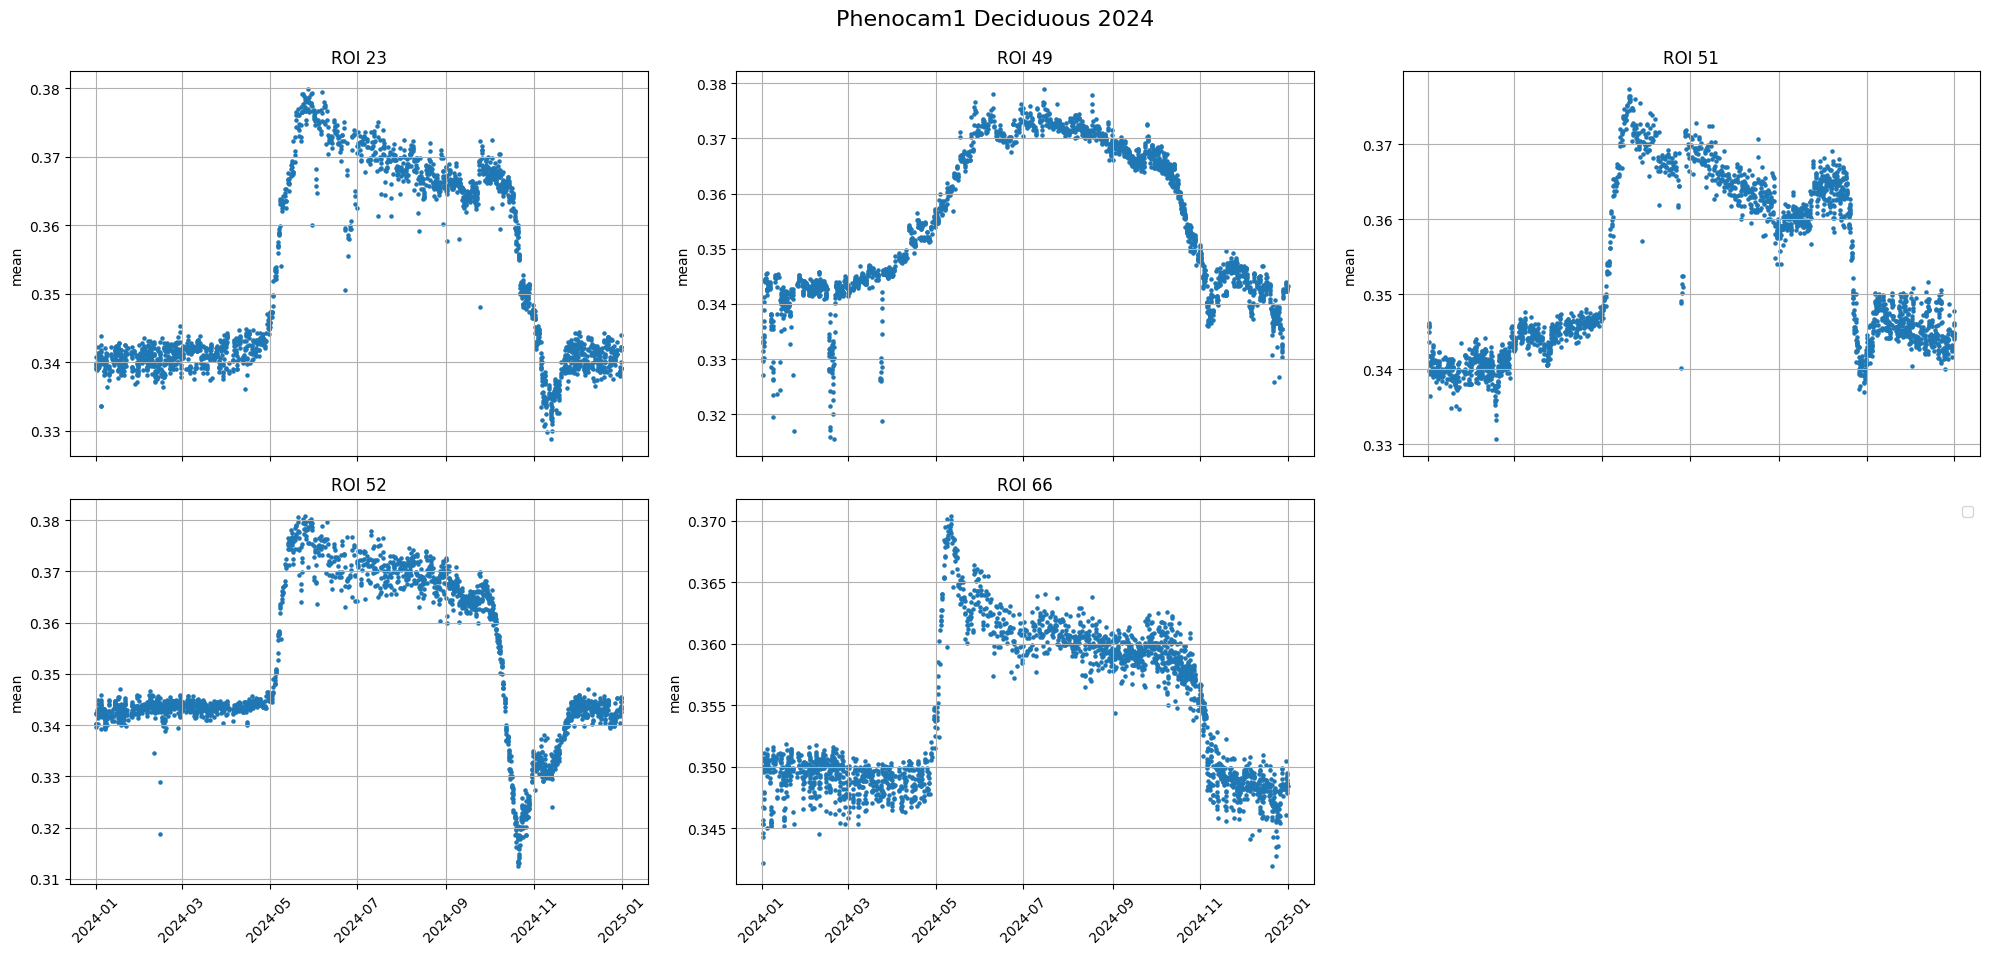

In [ ]:
PER_ROI_GCC_WITH_ALIGNMENT = "gcc_roi_with_alignment.csv"

df = pd.read_csv(FOLDER_DIR + PER_ROI_GCC_WITH_ALIGNMENT)
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.sort_values(by=['roi_id', 'datetime']).reset_index(drop=True)

group_column = 'roi_id'
x_column = 'datetime'
y_column = 'mean'
unique_keys = df[group_column].unique()

deciduous_keys = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
pine_keys = [27, 28]
grass_keys = [23, 49, 51, 52, 66]
unique_keys = grass_keys

# Prepare for plotting
n_keys = len(unique_keys[:9])
n_cols = 3
n_rows = (n_keys + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharex=False)
axes = axes.flatten()

# Collect metrics
columns = ['roi_id', 'sos', 'eos', 'los', 'peak_time', 'peak_value']
rows = []

for i, key in enumerate(unique_keys[:9]):
    subset = df[df[group_column] == key]
    subset = subset[subset[x_column].dt.year == 2024]

    ax = axes[i]
    ax.scatter(subset[x_column], subset[y_column], s=5, label='Observed (2024)')

    ax.set_title(f'ROI {key}')
    ax.set_ylabel(y_column)
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

for i, ax in enumerate(axes):
    if i // n_cols != n_rows - 1:  # Not in last row
        ax.set_xticklabels([])
        ax.set_xlabel("")  # Optional: also hide label
    else:
        ax.tick_params(axis='x', labelrotation=45)

plt.suptitle("Phenocam1 Deciduous 2024", fontsize=16, y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.legend()
plt.show()

# Create summary dataframe
stats = pd.DataFrame(rows, columns=columns)


<h3> 3.4 RCC and ExG </h3>

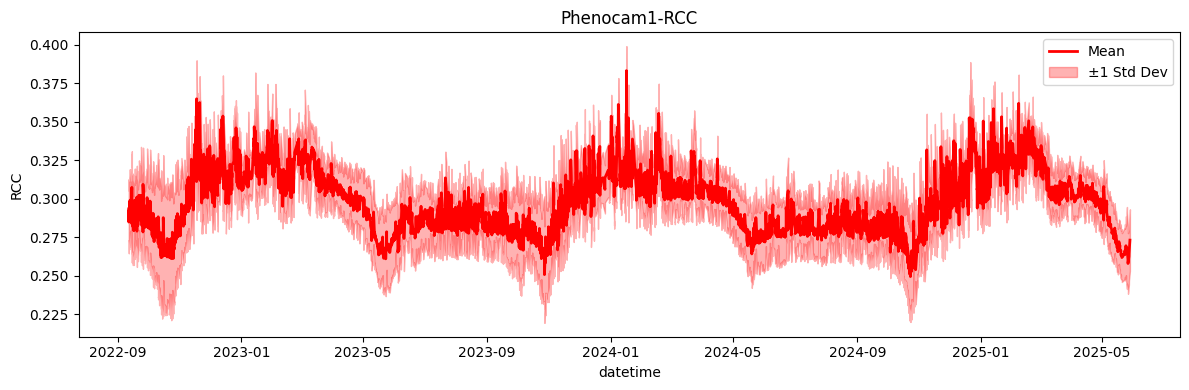

In [52]:
df = pd.read_csv('/Volumes/Aiqi_02/phenocams/tame_phenocams/test/index_global_Jul2.csv', parse_dates=['datetime'])

# Plot RCC
plot_gcc_with_gap_breaks(
    dates=df['datetime'],
    mean=df['rcc_mean'],
    std=df['rcc_std'],
    title='Phenocam1-RCC',
    ylabel='RCC',
    xlabel='datetime',
    color='red'
)

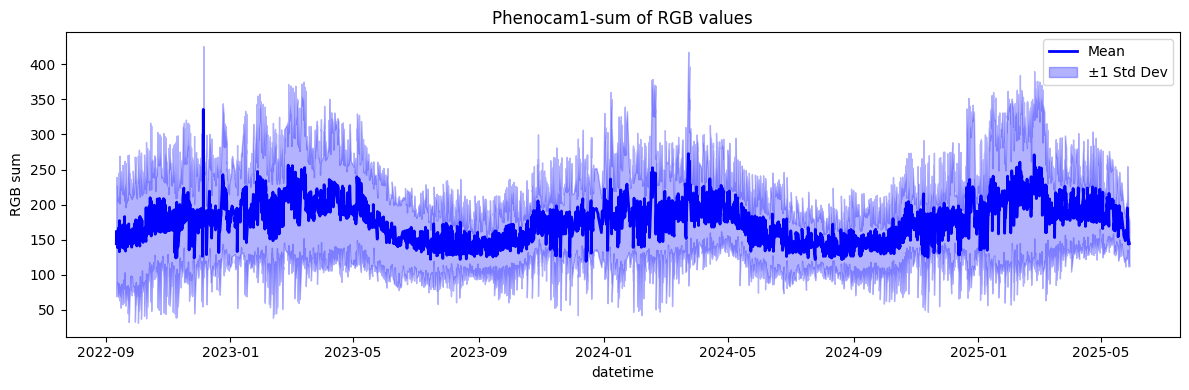

In [55]:
df = pd.read_csv('/Volumes/Aiqi_02/phenocams/tame_phenocams/test/index_global_Jul2.csv', parse_dates=['datetime'])

# Plot RCC
plot_gcc_with_gap_breaks(
    dates=df['datetime'],
    mean=df['rgbsum_mean'],
    std=df['rgbsum_std'],
    title='Phenocam1-sum of RGB values',
    ylabel='RGB sum',
    xlabel='datetime',
    color='blue'
)

<h2> 4. Key Parameter Extraction </h2>

In [ ]:
def ads_model(t, w1, t1, w2, t2, b, m):
    return b + m * ((1 / (1 + np.exp(-w1 * (t - t1)))) *
                    (1 - (1 / (1 + np.exp(-w2 * (t - t2))))))

'''
other options of models... (TIMESAT)
noisy option & ...
'''

def fit_gcc_series(dates, gcc_values):
    # Convert dates to day-of-year
    doy = pd.to_datetime(dates).dt.dayofyear
    t = np.array(doy)
    y = np.array(gcc_values)

    # Filter out invalid (NaN or inf) entries
    valid_mask = np.isfinite(t) & np.isfinite(y)
    t = t[valid_mask]
    y = y[valid_mask]

    # Return early if insufficient valid points
    if len(t) < 10:
        return None, None, None

    # Initial parameter guess: [a1, b1, a2, b2, c, d]
    p0 = [0.2, 130, 0.2, 280, 0.33, 0.06]
    bounds = ([0.01, 90, 0.01, 220, 0.3, 0.01],
              [2.0, 160, 2.0, 330, 0.4, 0.15])

    try:
        popt, _ = curve_fit(ads_model, t, y, p0=p0, bounds=bounds, maxfev=20000)
    except Exception as e:
        print("Curve fitting failed:", e)
        return None, None, None

    # Generate smoothed curve
    t_fit = np.linspace(t.min(), t.max(), 300)
    y_fit = ads_model(t_fit, *popt)
    return t_fit, y_fit, popt

def extract_season_dates(t_range, popt, threshold_start = 0.15, threshold_end = 0.85):
    t_range = np.arange(1, 366)
    y_fit = ads_model(t_range, *popt)
    b, m = popt[4], popt[5]

    peak_idx = np.argmax(y_fit)
    threshold_10 = b + threshold_start * m
    threshold_90 = b + threshold_end * m

    # SOS: first time before peak where curve rises above 10%
    for t, y in zip(t_range[:peak_idx], y_fit[:peak_idx]):
        if y > threshold_10:
            sos = t
            break
    else:
        sos = None  # If never crossed, fallback

    # EOS: first time after peak where curve drops below 90%
    for t, y in zip(t_range[peak_idx:], y_fit[peak_idx:]):
        if y < threshold_90:
            eos = t
            break
    else:
        eos = None
    
    if sos is not None and eos is not None:
        los = eos - sos
    else:
        los = None

    peak_idx = np.argmax(y_fit)
    peak_time = t_range[peak_idx]
    peak_value = y_fit[peak_idx]

    print("start of season:", sos)
    print("end of season:", eos)
    print("length of season:", los)
    print("peak greeness time:", peak_time)
    print("peak greeness value:", peak_value)

    return sos, eos, los, peak_time

def plot_dual_shadded(ax, region_labels, mean_vals, std_vals, min_vals, max_vals,
                      t_fit=None, y_fit=None, sos=None, eos=None, pk=None, title='2024 GCC Time Series'):
    
    ax.clear()
    region_labels = pd.to_datetime(region_labels)
    year_mask = region_labels.dt.year == 2024

    mean_vals = np.array(mean_vals[year_mask])
    std_vals = np.array(std_vals[year_mask])
    min_vals = np.array(min_vals[year_mask])
    max_vals = np.array(max_vals[year_mask])
    region_labels = pd.to_datetime(region_labels[year_mask])
    doy = region_labels.dt.dayofyear

    # === Plot GCC mean and shaded std dev ===
    ax.plot(doy, mean_vals, label='Mean GCC', color='green', linewidth=2)
    ax.fill_between(doy, mean_vals - std_vals, mean_vals + std_vals,
                    color='green', alpha=0.3, label='±1 Std Dev')

    # === Fitted curve ===
    if t_fit is not None and y_fit is not None:
        t_fit = np.array(t_fit)
        y_fit = np.array(y_fit)
        valid_mask = np.isfinite(t_fit) & np.isfinite(y_fit)
        if valid_mask.any():
            ax.plot(t_fit[valid_mask], y_fit[valid_mask], color='black', linestyle='--', label='Fitted Curve')

    # === Seasonal markers ===
    if sos is not None:
        ax.axvline(sos, color='blue', linestyle=':', label='SOS')
    if eos is not None:
        ax.axvline(eos, color='red', linestyle=':', label='EOS')
    if pk is not None:
        ax.axvline(pk, color='purple', linestyle=':', label='Peak')
    ax.legend()
    ax.set_title(title)
    ax.set_ylabel('GCC')
    ax.set_xlim(0, 365)



Phenocam01
start of season: 119
end of season: 277
length of season: 158
peak greeness time: 189
peak greeness value: 0.37622782179129693
Phenocam02
start of season: 113
end of season: 266
length of season: 153
peak greeness time: 169
peak greeness value: 0.3608049718446332


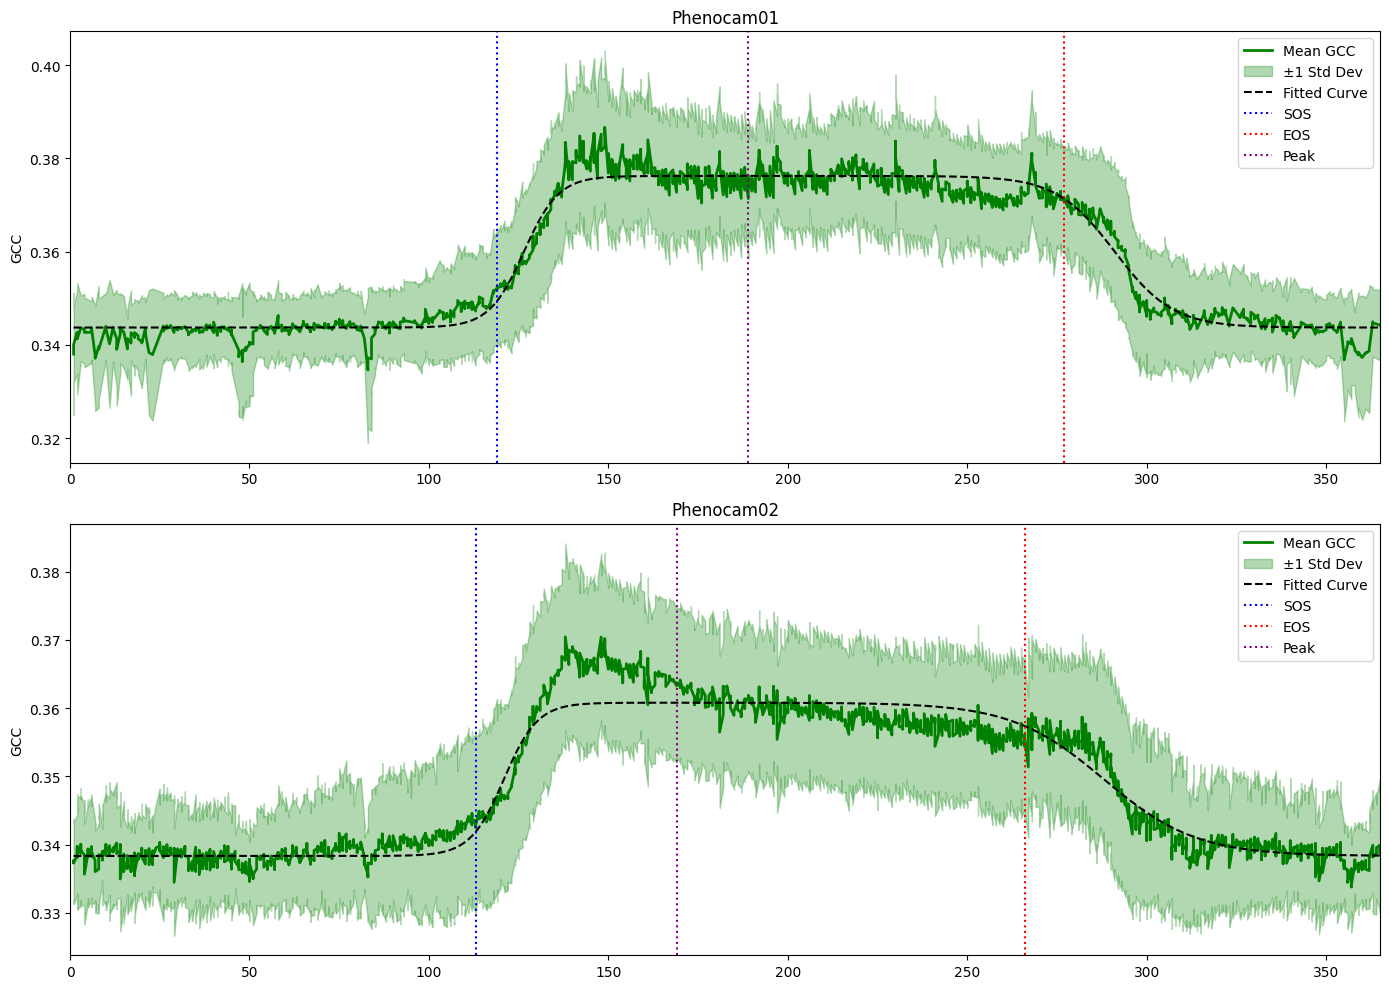

In [75]:
file_paths = [
    '/Volumes/Aiqi_02/phenocams/tame_phenocams/test/gcc_global_02.csv',
    '/Volumes/Aiqi_02/phenocams/tame_phenocams/phenocam02/gcc_global.csv'
]
titles = ['Phenocam01', 'Phenocam02']

target_time1 = pd.to_datetime("2024-01-01 12:00:00")
target_time2 = pd.to_datetime("2024-12-31 12:00:00")

fig, axs = plt.subplots(2, 1, figsize=(14, 10))
axs = axs.flatten()

for i, (path, title) in enumerate(zip(file_paths, titles)):
    df = pd.read_csv(path)
    print(title)
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df = df.sort_values(by="datetime").reset_index(drop=True)

    # Slice to desired year range
    idx1 = np.abs(df["datetime"] - target_time1).idxmin()
    idx2 = np.abs(df["datetime"] - target_time2).idxmin()
    df = df.loc[idx1:idx2].reset_index(drop=True)

    # Fit curve & extract seasonal metrics
    t_fit, y_fit, params = fit_gcc_series(df['datetime'], df['mean'])
    t_range = np.arange(1, 366)
    sos, eos, los, pk = extract_season_dates(t_range, params)

    # Plot
    plot_dual_shadded(axs[i], df['datetime'], df['mean'], df['std'], df['min'], df['max'],
                      t_fit=t_fit, y_fit=y_fit, sos=sos, eos=eos, pk=pk, title=title)

plt.tight_layout()
plt.show()